In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,0.0,0.49,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,0.0,0.48,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [6]:
ng_fields = [ 'contract_type', 'fuel_cost', 'natural_gas_delivery_contract_type', 'natural_gas_supply_contract_type', 'natural_gas_transportation_service', 'operator_id',  'plant_id', 'plant_state', 'primary_transportation_mode', 'purchase_type', 'quantity', 'regulated', "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "mmbtu_per_unit_gen", "disturbance_events", "number_affected"]

# Checking Correlations

In [6]:
# Label encode categorical fields so that they can be correlated
df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_ng[ng_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_ng[not_encode].reset_index()
temp2 = df_ng[to_encode].apply(le.fit_transform).reset_index()
df_ng = temp1.merge(temp2, on="index").set_index("index")

In [7]:
corr = df_ng.corr()

In [8]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['natural_gas_delivery_contract_type',
  'natural_gas_supply_contract_type',
  0.9949670257245146],
 ['natural_gas_supply_contract_type',
  'natural_gas_delivery_contract_type',
  0.9949670257245146],
 ['disturbance_events', 'number_affected', 0.7655082998226197],
 ['number_affected', 'disturbance_events', 0.7655082998226197],
 ['mmbtu_per_unit_gen', 'reported_prime_mover', 0.4551813724903194],
 ['natural_gas_transportation_service', 'purchase_type', 0.375298202366619],
 ['purchase_type', 'natural_gas_transportation_service', 0.375298202366619],
 ['contract_type', 'natural_gas_delivery_contract_type', 0.35006057060938583],
 ['natural_gas_delivery_contract_type', 'contract_type', 0.35006057060938583],
 ['contract_type', 'natural_gas_supply_contract_type', 0.34927582099496446],
 ['natural_gas_supply_contract_type', 'contract_type', 0.34927582099496446],
 ['primary_transportation_mode', 'purchase_type', 0.2942462825380524],
 ['purchase_type', 'primary_transportation_mode', 0.294246282538

Some obvious correlations in here, like gas supply and delivery contract type or disturbance events and number affected (by disturbance events). It helps give an idea of the data, btu it doesn't indicate any changes to features.

### Checking Correlations Involving Fuel Cost

In [9]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'number_affected', 0.016547105838107864],
 ['fuel_cost', 'regulated', nan],
 ['number_affected', 'fuel_cost', 0.016547105838107864],
 ['fuel_cost', 'disturbance_events', 0.008163806819898293],
 ['disturbance_events', 'fuel_cost', 0.008163806819898293],
 ['fuel_cost', 'reporting_frequency', 0.005495275823372207],
 ['reporting_frequency', 'fuel_cost', 0.005495275823372207],
 ['fuel_cost', 'nerc_region', 0.00423735556784291],
 ['nerc_region', 'fuel_cost', 0.00423735556784291],
 ['fuel_cost', 'plant_id', 0.003095974637123335],
 ['plant_id', 'fuel_cost', 0.003095974637123335],
 ['fuel_cost', 'primary_transportation_mode', 0.002930004254140046],
 ['primary_transportation_mode', 'fuel_cost', 0.002930004254140046],
 ['fuel_cost', 'supplier', 0.00274519529513206],
 ['supplier', 'fuel_cost', 0.00274519529513206],
 ['fuel_cost', 'natural_gas_supply_contract_type', 0.0006275626240884574],
 ['natural_gas_supply_contract_type', 'fuel_cost', 0.0006275626240884574],
 ['fuel_cost', 'natu

Interesting that disturbance events and number affected are correlated to fuel cost, but the correlation is not high. Same for other correlations: interesting but not strong enough to infer anything. On to modelling.

# Modelling

In [3]:
def get_ng():
    df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
    not_encode = []
    to_encode = []
    for fld, fld_type in df_ng[ng_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    temp1 = df_ng[not_encode].reset_index()
    temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
    df_ng = temp1.merge(temp2, on="index").set_index("index")
    return df_ng

In [37]:
df_ng = get_ng()
X = df_ng.drop(columns=["fuel_cost"])
y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [38]:
model = DecisionTreeClassifier(random_state=23)
results = model.fit(X_train, y_train)

In [39]:
results.score(X_test, y_test)

0.950568996666108

Decent score for accuracy, indicating better than baseline == "no price spikes" for the imbalanced model (p=.9). But f1 score will be the better determinant.

In [41]:
y_pred = results.predict(X_test)
f1_score(y_test, y_pred)

0.74593145701704

In [151]:
cross_val_score(results, X, y, cv=5)

array([0.46182787, 0.87096534, 0.90033711, 0.88595854, 0.88601229])

In [152]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.41363004016080623
plant_id 0.0713917231275164
primary_transportation_mode_PL 0.045662009500960075
mmbtu_per_unit_gen 0.04450722542000971
number_affected 0.01678085025869923
operator_id_19876.0 0.010048086071635369
operator_id_16534.0 0.009845627609527044
operator_id_16572.0 0.009595297508235833
nerc_region_SPP 0.009586190988073787
purchase_type_N/A 0.009371929392257046
disturbance_events 0.008481261145606243
supplier_VARIOUS 0.00829040315056773
natural_gas_transportation_service_F 0.007485496010826452
contract_type_S 0.007369196063739356
reporting_frequency_M 0.006768845930993168
nerc_region_NPCC 0.006169875340367029
nerc_region_MRO 0.00568244001320312
supplier_LG&E 0.005518598160978308
contract_type_C 0.0048545605825934535
supplier_BPE 0.004821543197242378
reported_prime_mover_GT 0.004460981611285116
nerc_region_FRCC 0.004286813272566593
natural_gas_transportation_service_I 0.00404422327967339
supplier_MUNIGAS - BP ENERGY 0.004009497231895011
operator_id_11249.0 0.003972742

operator_id_11740.0 0.0
operator_id_12524.0 0.0
operator_id_12647.0 0.0
operator_id_12927.0 0.0
operator_id_13228.0 0.0
operator_id_13407.0 0.0
operator_id_13488.0 0.0
operator_id_13809.0 0.0
operator_id_14077.0 0.0
operator_id_14127.0 0.0
operator_id_14194.0 0.0
operator_id_14232.0 0.0
operator_id_14268.0 0.0
operator_id_14605.0 0.0
operator_id_15472.0 0.0
operator_id_15776.0 0.0
operator_id_16088.0 0.0
operator_id_16183.0 0.0
operator_id_16295.0 0.0
operator_id_1692.0 0.0
operator_id_17609.0 0.0
operator_id_17697.0 0.0
operator_id_17874.0 0.0
operator_id_18445.0 0.0
operator_id_189.0 0.0
operator_id_19558.0 0.0
operator_id_19728.0 0.0
operator_id_20421.0 0.0
operator_id_20858.0 0.0
operator_id_22053.0 0.0
operator_id_23279.0 0.0
operator_id_24431.0 0.0
operator_id_2548.0 0.0
operator_id_26253.0 0.0
operator_id_30151.0 0.0
operator_id_3522.0 0.0
operator_id_39347.0 0.0
operator_id_40582.0 0.0
operator_id_40613.0 0.0
operator_id_40614.0 0.0
operator_id_4363.0 0.0
operator_id_4716.0 0.0

In [13]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))

In [14]:
conf

,0,1
0,47070,1307
1,1355,3959


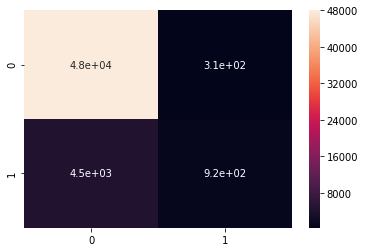

In [33]:
sns.heatmap(conf, annot=True)

While score is good, f1-score is terrible. Because the data is imbalanced - few price spikes overall - need to use SMOTE to account.

In [136]:
# Show imbalance of data
len(df_ng[df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9)])/len(df_ng)

0.09997988482198067

# Modelling with SMOTE

In [22]:
len(df)

440666

In [33]:
from imblearn.over_sampling import ADASYN
sm = ADASYN()
#sm = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [34]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [35]:
y_pred = results.predict(X_test)

In [27]:
results.score(X_test, y_test)

0.8849363033599046

In [36]:
f1_score(y_test, y_pred)

0.3390939768892525

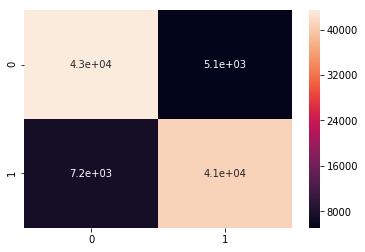

In [40]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [42]:
conf

,0,1
0,43376,5112
1,7231,40927


In [41]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

purchase_type_N/A 0.2799305828141
primary_transportation_mode_PL 0.07928082279993348
reported_prime_mover_GT 0.07184211463895088
contract_type_N/A 0.06718664238361852
reported_prime_mover_CT 0.06708855177363116
operator_id_16534.0 0.05420646565799079
primary_transportation_mode_N/A 0.05362530537563987
reporting_frequency_A 0.05090233171439193
quantity 0.04462028261507721
reported_prime_mover_CA 0.0351246197887928
reported_prime_mover_ST 0.02859605804556457
supplier_VARIOUS 0.021910232392130496
mmbtu_per_unit_gen 0.011873009741851842
plant_id 0.011128545875214193
number_affected 0.009897761099937607
nerc_region_SPP 0.009260532782398617
plant_state_AZ 0.008343999122734444
plant_state_VA 0.005680729730602374
natural_gas_transportation_service_I 0.0056406480111331455
plant_state_WA 0.005545549702925694
contract_type_S 0.005389232556217691
operator_id_19876.0 0.005311115719079142
supplier_VARIOUS (NATURAL GAS SPOT PURCHASES ONLY) 0.004812623326551191
nerc_region_MRO 0.0040960376249761345
op

supplier_FLORIDA GAS TRANSMISSION 0.0
supplier_FLORIDA GAS UTILITY 0.0
supplier_FLORIDA POWER & LIGHT 0.0
supplier_FORTIS ENERGY 0.0
supplier_FORTIS ENERGY MARKETING & TRADING GP 0.0
supplier_FREEPOINT COMMODITIES LLC 0.0
supplier_FURIE OPERATING ALASKA, LLC 0.0
supplier_GAS COMPANY OF NEW MEXICO 0.0
supplier_GASEARCH 0.0
supplier_GAZPROM MT 0.0
supplier_GOLDMAN SACHS 0.0
supplier_GORDONSVILLE 0.0
supplier_GREEN PLAINS TRADE GROUP LLC 0.0
supplier_GULF SOUTH PIPELINE, LP 0.0
supplier_GULF STREAM 0.0
supplier_GULFSOUTH PIPELINE 0.0
supplier_GUNVOR USA LLC 0.0
supplier_Gavilon 0.0
supplier_Gulf South 0.0
supplier_HESS 0.0
supplier_HESS ENERGY 0.0
supplier_HIGH PLAINS BIOENERGY,LLC 0.0
supplier_HILCORP ENERGY CO 0.0
supplier_HOUSTON PIPE LINE 0.0
supplier_HOUSTON PIPELINE COMPANY 0.0
supplier_HPL 0.0
supplier_HUSKY ENERGY 0.0
supplier_HYDROCARBON EXCHANGE CORP 0.0
supplier_Hess Corp 0.0
supplier_IBERDROLA RENEWABLES 0.0
supplier_IBERDROLA RENEWABLES CANADA 0.0
supplier_IDAHO POWER 0.0
sup

# Analyze False Positives and Negatives

In [42]:
y_pred = results.predict(X)

In [43]:
wrongs = (y_pred != y)

In [44]:
df_ng["wrong"] = wrongs

In [45]:
df_ng[df_ng["wrong"] == True]["natural_gas_delivery_contract_type_N/A"].value_counts()

1    2769
0     152
Name: natural_gas_delivery_contract_type_N/A, dtype: int64

After some trial and error, large number of incorrect values have a delivery contract of "N/A". Maybe we can subset the data of those values and use a separate model.

# Subsetting the Data  Part 1 - Where Delivery Contract != N/A

In [46]:
df_ng = get_ng()
df_ng2 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] != 1)].drop(columns="wrong")

In [47]:
X = df_ng2.drop(columns="fuel_cost")
y = (df_ng2.fuel_cost > df_ng.fuel_cost.quantile(.9))

In [48]:
#sm = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)


In [49]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [50]:
y_pred = results.predict(X_test)

In [52]:
results.score(X_test, y_test)

0.9775696327335469

In [51]:
f1_score(y_test, y_pred)

0.5098743267504489

Even better F1-score on the subset.

In [53]:
# Saving the test and prediction data for later use
leaf1_test = y_test
leaf1_pred = y_pred

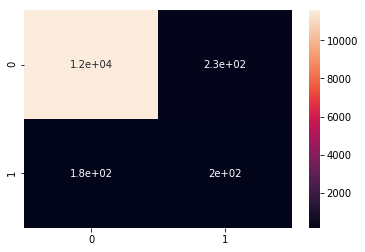

In [33]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [34]:
conf

,0,1
0,11567,228
1,178,198


In [97]:
cross_val_score(results, X_res, y_res, cv=5)

array([0.92150446, 0.94759881, 0.93289418, 0.93574161, 0.94376913])

No abberations in cross_val_score

# Modeling Subset of Data - Delivery Contract == N/A

In [54]:
df_ng3 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] == 1)].drop(columns="wrong")

In [70]:
X = df_ng3.drop(columns="fuel_cost")
y = (df_ng3.fuel_cost > df_ng.fuel_cost.quantile(.9))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)


In [68]:
model = DecisionTreeClassifier()
results = model.fit(X_train, y_train)

In [69]:
y_pred = results.predict(X_test)
f1_score(y_pred, y_test)

0.7340393343419063

Great, good F1-Score on the other subset as well.

In [59]:
leaf2_pred = y_pred
leaf2_test = y_test

In [60]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.41893670246798803
mmbtu_per_unit_gen 0.05084376716905092
primary_transportation_mode_PL 0.03813938764423704
disturbance_events 0.016888273465804782
nerc_region_NPCC 0.015259691525142161
number_affected 0.010421556042768386
supplier_VARIOUS 0.010317224208931922
operator_id_19876.0 0.009684042814513294
operator_id_12745.0 0.009175379965376157
contract_type_C 0.008618494527918012
nerc_region_MRO 0.007246152478975517
reporting_frequency_A 0.006524753018230884
supplier_LG&E 0.0057883227880850836
natural_gas_transportation_service_F 0.005729343367295372
reported_prime_mover_GT 0.005302257499895331
contract_type_S 0.004948406501932435
supplier_BPE 0.0049469872908863245
plant_id_7527 0.004617568963279203
supplier_MUNIGAS - BP ENERGY 0.0044083604669335735
plant_id_141 0.004392011780918869
nerc_region_FRCC 0.004362518761513591
plant_state_CA 0.004358768435711043
operator_id_11249.0 0.0043118098726544415
natural_gas_transportation_service_I 0.004288492780397586
secondary_transportation

supplier_TEJAS GAS 6.525015820409403e-05
plant_id_6253 6.481146343162629e-05
supplier_COLUMBIA 6.408062725293318e-05
operator_id_17632.0 6.398421891513553e-05
plant_id_7512 6.383984426732701e-05
supplier_CONCORD 6.343107875982918e-05
plant_id_6120 6.32592901279912e-05
operator_id_17539.0 6.287257389964022e-05
plant_id_404 6.225149477913945e-05
plant_id_7932 6.177103284749023e-05
supplier_QEP RESOURCES 6.1749041491994e-05
plant_id_8067 6.099791974489327e-05
plant_id_4937 6.0925906705041537e-05
plant_id_55129 6.062538788669368e-05
plant_id_2144 6.039157282173778e-05
plant_id_1822 6.03539792387734e-05
supplier_COLUMBIA GULF 6.009546002069917e-05
plant_id_7988 5.993075607235103e-05
plant_id_3992 5.985955167685518e-05
plant_id_56143 5.9644075044174624e-05
plant_state_CT 5.9485688222308485e-05
operator_id_16655.0 5.929945851787215e-05
plant_id_1012 5.888714751431027e-05
supplier_TARGA 5.78006394028592e-05
supplier_Regency FS 5.774647353095705e-05
plant_id_4041 5.756694769220881e-05
supplier_

plant_id_3648 0.0
plant_id_377 0.0
plant_id_3775 0.0
plant_id_3944 0.0
plant_id_3946 0.0
plant_id_3982 0.0
plant_id_4014 0.0
plant_id_4048 0.0
plant_id_4076 0.0
plant_id_4195 0.0
plant_id_4259 0.0
plant_id_464 0.0
plant_id_47 0.0
plant_id_478 0.0
plant_id_492 0.0
plant_id_493 0.0
plant_id_525 0.0
plant_id_54537 0.0
plant_id_550 0.0
plant_id_55063 0.0
plant_id_55065 0.0
plant_id_55087 0.0
plant_id_55135 0.0
plant_id_55164 0.0
plant_id_55173 0.0
plant_id_55218 0.0
plant_id_55244 0.0
plant_id_55247 0.0
plant_id_55269 0.0
plant_id_55270 0.0
plant_id_55306 0.0
plant_id_55322 0.0
plant_id_55364 0.0
plant_id_55380 0.0
plant_id_55382 0.0
plant_id_55386 0.0
plant_id_55395 0.0
plant_id_55402 0.0
plant_id_55412 0.0
plant_id_55418 0.0
plant_id_55447 0.0
plant_id_55451 0.0
plant_id_55467 0.0
plant_id_55514 0.0
plant_id_55622 0.0
plant_id_55645 0.0
plant_id_55664 0.0
plant_id_55694 0.0
plant_id_55701 0.0
plant_id_55714 0.0
plant_id_55718 0.0
plant_id_55835 0.0
plant_id_55836 0.0
plant_id_55939 0.0
p

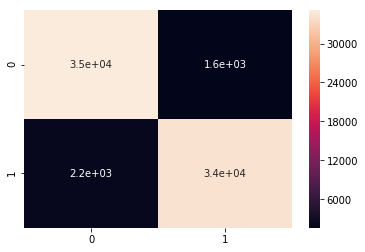

In [137]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [138]:
conf

,0,1
0,35123,1591
1,2173,34229


# Combine the Two Leafs to Find Out Combined F1 Score

In [61]:
leaf1_pred = pd.DataFrame(leaf1_pred)
leaf2_pred = pd.DataFrame(leaf2_pred)
leaf1_test = pd.DataFrame(leaf1_test)
leaf2_test = pd.DataFrame(leaf2_test)

leafs_pred = leaf1_pred.append(leaf2_pred)
leafs_test = leaf1_test.append(leaf2_test)

In [62]:
f1_score(leafs_pred, leafs_test)

0.7210342146189735